In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import io
import glob
import random
import sys
import tensorflow as tf
import keras
import pandas as pd
from keras.layers import *
from keras.models import *
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get file path
train_data_path = list()
label_data_path = list()
lane_status_path = list()
label_selfcreate_path = list()

with open('/content/drive/My Drive/CULane/train_gt.txt', 'r') as f: 
  for i in range (88880): #limit all - 88880 
    string = f.readline()
    # print(string[0:19])

    if string[0:19] == "/driver_161_90frame":

      line = f.readline().split(' ')
      line[-1] = line[-1].replace('\n', '')
  
      a = '/content/drive/My Drive/CULane'+line[0]
      b = '/content/drive/My Drive/CULane'+line[1]
      c = line[2:]

      d = a.replace('jpg', 'lines.txt')

      # Train_Dataset_path.append([train_data, label_data, lane_status])
      train_data_path.append(a)
      label_data_path.append(b)
      lane_status_path.append(c)
      label_selfcreate_path.append(d)

print(train_data_path)
print(label_data_path)
print(lane_status_path)
print(label_selfcreate_path)

['/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00090.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00270.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00450.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00630.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00810.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00990.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01170.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01350.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01530.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01710.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01890.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/02070.jpg', '/content/drive/My Drive/CU

(7000, 128, 128, 3)
(7000, 128, 128)


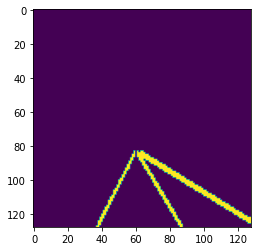

In [ ]:
# utlize label in dataset
images, labels = [], []

# alpha = 1.3 # Contrast control (1.0-3.0)
# beta = 85 # Brightness control (0-100)

for j in range (7000):

  #resize image 
  image = cv2.imread(train_data_path[j],1)  # Reading Image in RGB format
  image = cv2.resize(image, (128, 128))
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)
  # plt.imshow(image)

  label = cv2.imread(label_data_path[j],0)
  label = cv2.resize(label, (128, 128))
  
  # binary image
  for n in range(128):
    for m in range(128):
      if label[n,m] != 0:
        label[n,m] = 255
  # label  = cv2.threshold(label , thresh, 255, cv2.THRESH_BINARY)[1]
  
  plt.imshow(label)

  # Normalizing the image
  image = image / 255.0
  label = label / 255.0
  
  images.append(image)
  labels.append(label)

images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)
# The resolution of individual image is : 1640x590.

In [ ]:
# generate own label by text file
# labels_selfcreate = []

# for k in range (2000):
#   label_selfcreate_txt = open(label_selfcreate_path[k], "r")
#   # if label_selfcreate_txt.mode == 'r':
#   contents = label_selfcreate_txt.read()
#   lines_text = contents.split('\n')

#   x_coordinate, y_coordinate, lanes = [], [], []

#   for line_text in lines_text:
#     number_lines = line_text.split(" ")
#     number_lines.pop()

#     x = list([float(number_lines[i]) for i in range(len(number_lines)) if i % 2 == 0])
#     y = list([float(number_lines[i]) for i in range(len(number_lines)) if i % 2 != 0])

#     x_coordinate.append(x)
#     y_coordinate.append(y)

#     lanes.append(set(zip(x, y)))

#   lanes.pop()
#   img = cv2.imread(train_data_path[k],1)
#   mask = np.zeros_like(img)
#   # colors = [[255,0,0], [0,255,0], [0,0,255], [255,255,0]]
#   colors = [[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255]]
#   for m in range(len(lanes)):
#     cv2.polylines(mask, np.int32([list(lanes[m])]), isClosed=True, color=colors[m], thickness=10)
#   label_selfcreate = cv2.cvtColor(mask, cv2.COLOR_BGR2XYZ) #BGR2XYZ
#   label_selfcreate = cv2.resize(label_selfcreate, (128, 128))
#   plt.imshow(label_selfcreate)

#   label_selfcreate = label_selfcreate / 255.0
#   labels_selfcreate.append(label_selfcreate)

# labels_selfcreate = np.array(labels_selfcreate)
# print(labels_selfcreate.shape)

In [ ]:
# split data
X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=0.1,random_state=42)
# X_train,X_test,y_train,y_test=train_test_split(images,labels_selfcreate,test_size=0.1,random_state=42)

In [ ]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((128, 128, 3))
output_layer = build_model(input_layer, 16)#16

In [ ]:
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 100, verbose=1, shuffle=False, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test)

Epoch 1/100
197/197 [==============================] - 53s 200ms/step - loss: 0.2164 - accuracy: 0.9707 - val_loss: 0.0831 - val_accuracy: 0.9741
Epoch 2/100
197/197 [==============================] - 37s 186ms/step - loss: 0.0798 - accuracy: 0.9740 - val_loss: 0.0757 - val_accuracy: 0.9741
Epoch 3/100
197/197 [==============================] - 37s 185ms/step - loss: 0.0755 - accuracy: 0.9740 - val_loss: 0.0736 - val_accuracy: 0.9741
Epoch 4/100
197/197 [==============================] - 37s 186ms/step - loss: 0.0745 - accuracy: 0.9740 - val_loss: 0.0722 - val_accuracy: 0.9741
Epoch 5/100
197/197 [==============================] - 37s 185ms/step - loss: 0.0730 - accuracy: 0.9740 - val_loss: 0.0701 - val_accuracy: 0.9746
Epoch 6/100
197/197 [==============================] - 37s 185ms/step - loss: 0.0706 - accuracy: 0.9747 - val_loss: 0.0669 - val_accuracy: 0.9759
Epoch 7/100
197/197 [==============================] - 36s 185ms/step - loss: 0.0667 - accuracy: 0.9758 - val_loss: 0.0619 -

[0.038391366600990295, 0.9859223961830139]

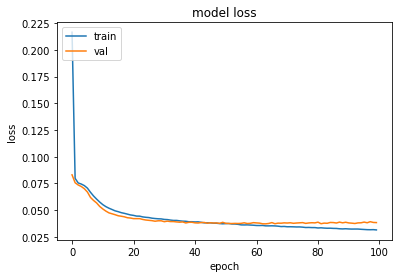

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
predict = model.predict(X_test)
print(predict.shape)
print(predict.dtype)
print(X_test.dtype)
print(y_test.dtype)
# from scipy import stats
# stats.describe(predict)

(700, 128, 128, 1)
float32
float64
float64


In [ ]:
# remove normarlization
image_example = X_test*255
label_example = y_test*255
label_predict = predict*255


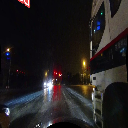

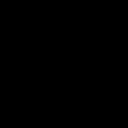

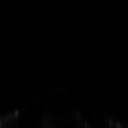

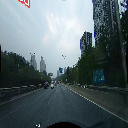

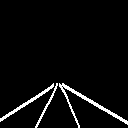

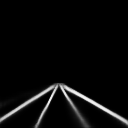

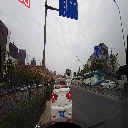

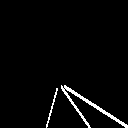

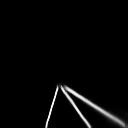

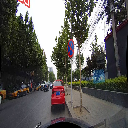

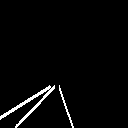

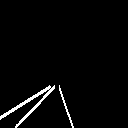

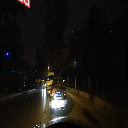

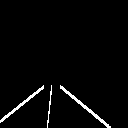

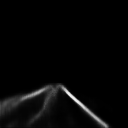

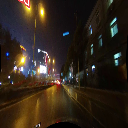

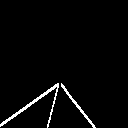

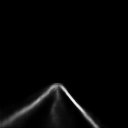

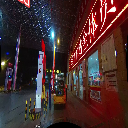

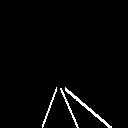

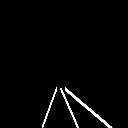

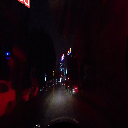

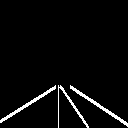

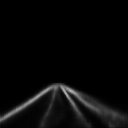

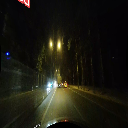

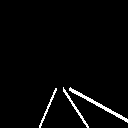

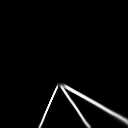

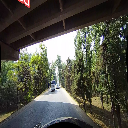

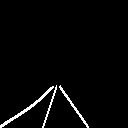

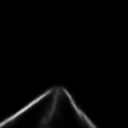

In [ ]:
# display result
for n in range(10):

  cv2_imshow(image_example[n,:,:,:])
  cv2_imshow(label_example[n,:,:])
  cv2_imshow(label_predict[n,:,:])

In [ ]:
# please see other python file for computer vision selection
# # choose R size
# r_step = 1
# rmax = np.sqrt(128 ** 2 + 128 ** 2)
# r_vec = np.arange(-rmax, rmax, r_step)

# # choose theta size
# t_step = np.pi / 180
# t_vec = np.arange(0, np.pi, t_step)

# # accumulation matrix
# acc_mat = np.zeros((r_vec.shape[0], t_vec.shape[0]))

# # get indices of edges
# mag_im = cv2.Canny(label_predict[0], 50, 400)
# edge_inds = np.argwhere(mag_im > 0)

# # run on all theta and edge indices and find corresponding R
# for t_ind, t0 in enumerate(t_vec):
#     for yx in edge_inds:
#         x = yx[1]
#         y = yx[0]

#         r0 = x * np.cos(t0) + y * np.sin(t0)
#         r_ind = np.argmin(np.abs(r0 - r_vec))

#         acc_mat[r_ind, t_ind] += 1


In [ ]:
# TH = 250
# acc_mat_th = acc_mat > TH
# # get indices of acc_mat_th
# edge_inds = np.argwhere(acc_mat_th > 0)

# res = image_example[0].copy()
# for r_ind, t_ind in edge_inds:
#     rho = r_vec[r_ind]
#     theta = t_vec[t_ind]

#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * rho
#     y0 = b * rho
#     x1 = int(x0 + 1000 * (-b))
#     y1 = int(y0 + 1000 * (a))
#     x2 = int(x0 - 1000 * (-b))
#     y2 = int(y0 - 1000 * (a))

#     res = cv2.line(res, (x1, y1), (x2, y2), (0, 0), thickness=1)

# cv2_imshow(res)
# # plt.imshow(res)
# # plt.show()